<a href="https://colab.research.google.com/github/zulyazqall/Sentiment_Analysis/blob/master/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install wordcloud

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/tweet_train.csv", delimiter=";")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/data_test.csv", delimiter="\t")

In [0]:
train.head()

,username,user_id,tweet_url,timestamp,text,sentimen,hashtags
0,aya,"8,65E+17",/aya_aya2772/status/1212236520427384832,01/01/20 04.58,The last sunset in 2019 \r\nHappy new year \r\...,0,"['sunset', 'beautifulsunset', 'sungkunbeach', ..."
1,Opan Lombok,"1,16E+18",/OpanLombok1/status/1212281086429974529,01/01/20 07.55,Happy hollyday \r\n.\r\n.\r\n.\r\n.\r\n.\r\n.\...,0,"['beautiful', 'lombok', 'indonesia', 'beach', ..."
2,aya,"8,65E+17",/aya_aya2772/status/1212236520427384832,01/01/20 04.58,The last sunset in 2019 \r\nHappy new year \r\...,0,"['sunset', 'beautifulsunset', 'sungkunbeach', ..."
3,Harry Budiarto,94705672,/harrybudiarto/status/1228632214667169792,15/02/20 10.48,Pemandangan menakjubkan di Pantai Mekaki.. #l...,1,"['latepost', 'lombok', 'lombokisland', 'lombok..."
4,Sandy Traveller,475886892,/lalu_sandika/status/1228421491483643904,14/02/20 20.51,"baunyale2020 at Pantai Seger Kuta Mandalika, L...",1,"['baunyale2020', 'wonderfulindonesia', 'wonder..."


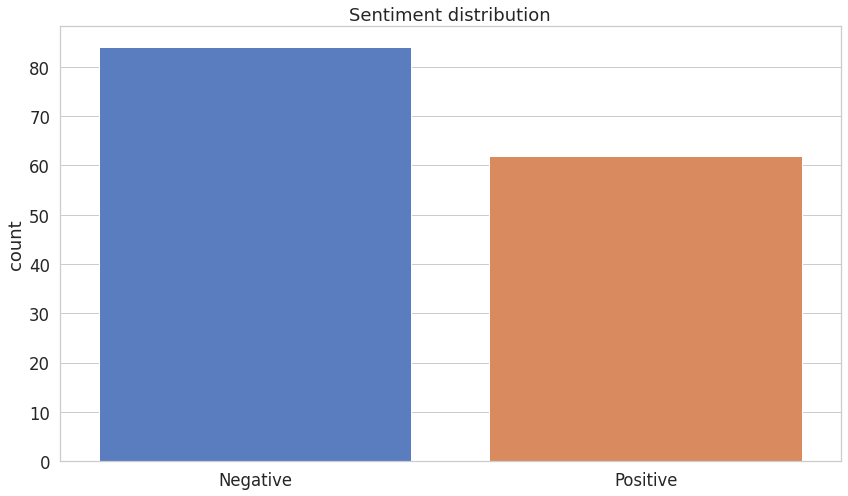

In [0]:
f = sns.countplot(x='sentimen', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

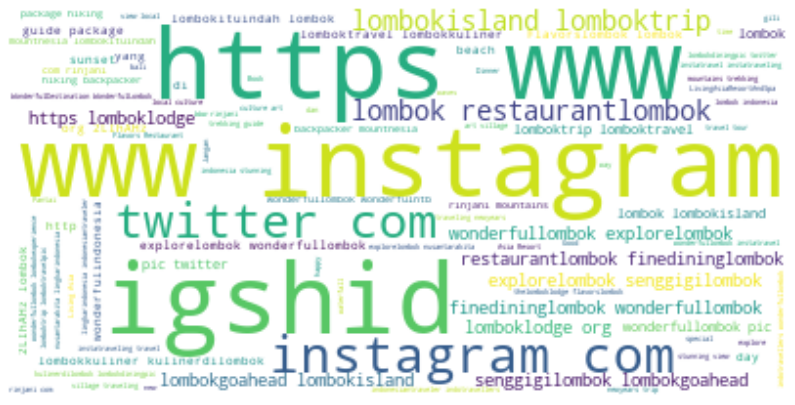

In [0]:
text = " ".join(text for text in train.text)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [0]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [0]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [0]:
X = train['text'].values
y = train['sentimen'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [0]:
y_hat = MNB.predict(X_test)

In [0]:
accuracy_score(y_test, y_hat)

0.6666666666666666

In [0]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.67      0.46      0.55        13

    accuracy                           0.67        30
   macro avg       0.67      0.64      0.64        30
weighted avg       0.67      0.67      0.65        30



In [0]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[14,  3],
       [ 7,  6]])

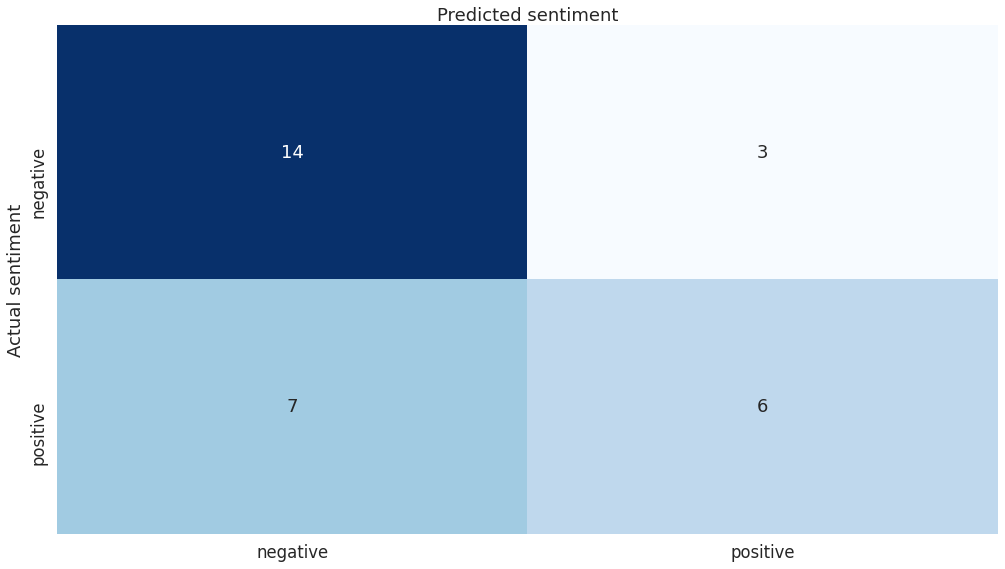

In [0]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');